# Pitch & Roll prediction w/Images

In [1]:
import gc
import os
import sys
import cv2
import json
import math
import pickle
import random
import platform
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [2]:
print(torch.__version__)
print(pl.__version__)

1.11.0
1.6.1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 16
Platform: windows
number of workers: 0


# Constants

In [9]:
# change to appropriate location
TRAIN_FOLDER = "../../3dmodel/test_4_episode_"
MODEL_NAME = "CNN_img-to-PR"
MODEL_STATE_FOLDER = f"../model_states/{MODEL_NAME}"
RESULT_FOLDER = f"../../results/{MODEL_NAME}"
TRAIN_RESULT_FOLDER = f"../training_results/{MODEL_NAME}"
TEST_RESULT_FOLDER = f"../test_results/{MODEL_NAME}"

In [10]:
if not os.path.exists(MODEL_STATE_FOLDER):
    os.mkdir(MODEL_STATE_FOLDER)
if not os.path.exists(TRAIN_RESULT_FOLDER):
    os.mkdir(TRAIN_RESULT_FOLDER)
if not os.path.exists(TEST_RESULT_FOLDER):
    os.mkdir(TEST_RESULT_FOLDER)
if not os.path.exists(RESULT_FOLDER):
    os.mkdir(RESULT_FOLDER)

In [ ]:
FRAMES_IN = 10
FRAMES_OUT = 60

N_EPISODES = 540
FRAMES_PER_EPISODE = 400

TRAIN_SIZE = 0.8
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

CUDA = device.type == 'cuda'

# Load data from episodes

In [6]:
current = os.path.dirname(os.path.realpath(''))
parent = os.path.dirname(current)
sys.path.append(parent)  

# del sys.modules["notebooks.data_loaders.utils"]
from notebooks.data_loaders.utils import Utilities
from notebooks.data_loaders.dataloader import CustomDataLoader
from notebooks.data_loaders.sequence_generator import SequenceGenerator

dl = CustomDataLoader(TRAIN_FOLDER, N_EPISODES, load_images=False)
dl.pr_data.shape

NameError: name 'N_EPISODES' is not defined

In [13]:
# build dataframe with pitch and roll, cast as float and normalize
p_r_df = pd.DataFrame(episodes_data)
p_r_df.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
print(p_r_df.shape)
p_r_df.head(5)

(216000, 2)


,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
2,0.069040,0.017904
3,0.013726,0.068616
4,0.014908,0.041061


In [14]:
# tranform the array of image tensors into one tensor of shape: (samples, height, width, channels)
img_tensor = torch.stack(img_tensors_array)
img_tensor_array = None # free this memory
img_tensor.shape

torch.Size([216000, 54, 96, 3])

In [15]:
# Permute from (n, h, w, c) to (n, c, h, w) format for pytorch CNN
img_tensor = img_tensor.permute(0,3,1,2)
img_tensor.shape

torch.Size([216000, 3, 54, 96])

In [16]:
# clear memory
gc.collect()

18

# Create input and output sequences

In [17]:
# function to create sequences with one target column
def create_sequences(
        input_data: pd.DataFrame, 
        input_images,
        input_feature_columns,
        output_target_columns, 
        input_sequence_length=FRAMES_IN, 
        output_sequence_length=FRAMES_OUT,  
        episode_length = FRAMES_PER_EPISODE, 
        n_episodes = N_EPISODES
    ):
    sequences= []

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):

        for l in range(episode_length-output_sequence_length-input_sequence_length+1):
            
            i = l+(n*episode_length)

            # grab image input tensors from list with img_tensors
            sequence = input_images[i:i+input_sequence_length]

            # grab pr output sequence from dataframe
            target_position = i + input_sequence_length
            target = input_data.iloc[target_position:target_position+output_sequence_length].transpose()

            sequences.append((sequence, target))

    return sequences

In [18]:
# use images to predict pitch and roll
input_features = []
output_features = ["pitch", "roll"]
all_sequences = create_sequences(p_r_df, img_tensor, input_features, output_features)

  0%|          | 0/540 [00:00<?, ?it/s]

In [19]:
len(all_sequences), all_sequences[0][0].shape , all_sequences[0][1].shape

(146340, torch.Size([10, 3, 54, 96]), (2, 120))

In [20]:
# first input sequence
all_sequences[0][0].shape

torch.Size([10, 3, 54, 96])

In [21]:
# first output sequence
all_sequences[0][1].head()

,10,11,12,13,14,15,16,17,18,19,...,120,121,122,123,124,125,126,127,128,129
pitch,0.029492,-0.003735,0.152513,0.091190,0.093264,-0.012752,0.095015,0.162501,0.103608,0.077369,...,0.108907,0.048199,0.046744,-0.055028,0.050729,0.066726,-0.006466,0.008570,0.070406,0.053108
roll,0.056080,0.063161,0.047668,0.016488,-0.019758,0.099169,0.120886,0.146725,0.127897,0.098694,...,0.017701,0.054243,0.072354,0.067578,0.094274,0.073411,0.081592,0.073875,0.060217,0.101653


In [22]:
# loop for testing sequence integrity
"""
i = 0
for data in tqdm(all_sequences):
    input = data[0]
    output = data[1]

    episode = input.iloc[0]["episode"]
    episode1 = output.iloc[0]["episode"]
    
    if(episode1 != episode):
        print("Input and output from different episodes")
        break

    if (len(input['episode'].unique()) != 1):
        print("input seq: "+i+" contains data from different episodes")
        break
    
    if (len(output['episode'].unique()) != 1):
        print("output seq: "+i+" contains data from different episodes")
        break
    
    i += 1
"""

'\ni = 0\nfor data in tqdm(all_sequences):\n    input = data[0]\n    output = data[1]\n\n    episode = input.iloc[0]["episode"]\n    episode1 = output.iloc[0]["episode"]\n    \n    if(episode1 != episode):\n        print("Input and output from different episodes")\n        break\n\n    if (len(input[\'episode\'].unique()) != 1):\n        print("input seq: "+i+" contains data from different episodes")\n        break\n    \n    if (len(output[\'episode\'].unique()) != 1):\n        print("output seq: "+i+" contains data from different episodes")\n        break\n    \n    i += 1\n'

In [23]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print("Training size:", len(train_indices),"| Test size:", len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
Training size: 117072 | Test size: 29268
[29184, 6556, 72097, 64196, 58513, 36579, 26868, 142964, 22790, 110604]
[0, 1, 3, 131082, 131087, 131088, 18, 21, 131094, 131100]


In [24]:
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
print(len(train_sequences), train_sequences[0][0].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0].shape, test_sequences[0][1].shape)

  0%|          | 0/117072 [00:00<?, ?it/s]

  0%|          | 0/29268 [00:00<?, ?it/s]

True
117072 torch.Size([10, 3, 54, 96]) (2, 120)
29268 torch.Size([10, 3, 54, 96]) (2, 120)


## Pytorch Dataset and DataLoader

In [25]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        input_sequence, output_sequence = self.sequences[index]

        return dict(
            input = input_sequence,
            output = torch.Tensor(output_sequence.to_numpy())
        )

In [26]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = BATCH_SIZE):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [27]:
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [28]:
# batch size first
for batch in data_module.train_dataloader():
    print(batch["input"].shape)
    print(batch["output"].shape)
    break

torch.Size([64, 10, 3, 54, 96])
torch.Size([64, 2, 120])


## CNN Model

In [29]:
class CNN_encoder(nn.Module):

    def __init__(self, channels=3):
        super(CNN_encoder, self).__init__()

        # outputs a tensor of shape (batch, out_channels, h/2/2, w/2/2)
        self.cnn_encoder = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=8, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
    
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x, batch_size):
        # x is of shape (batch, seq_lenth, channels, height, width)
        # iterate over the sequence and encode a feature vector for each image
        img_features = [self.cnn_encoder(x[:,i,:,:,:].squeeze(1)) for i in range(x.size(1))]
        
        # flatten feature vectors in img_features
        img_features = [img.reshape(batch_size, -1) for img in img_features]

        # convert list of vectors into tensor of shape: (batch, len(img_features), features)
        img_features = torch.stack(img_features, 1)

        # reshape into (batch, 1, n*features)
        img_features = img_features.reshape(batch_size, -1).unsqueeze(1)


        return img_features

In [30]:
# get the first batch out of the dataloader for testing purposes
for batch in data_module.train_dataloader():
    x_train = batch["input"]
    y_train = batch["output"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 10, 3, 54, 96]) torch.Size([64, 2, 120])


In [31]:
model = CNN_encoder()
img_features = model.forward(x_train, BATCH_SIZE)
img_features.shape

torch.Size([64, 1, 49920])

In [32]:
# ENCODER
class LSTM_encoder(nn.Module):
    def __init__(self, input_size, hidden_size=1024, num_layers=1):
       
        super(LSTM_encoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size

        self.encoder_lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,
        )

    def forward(self, input_seq):

        ouputs, hidden = self.encoder_lstm(input_seq)
        
        return ouputs, hidden

In [33]:
model = LSTM_encoder(img_features.size(2))
output, hidden = model.forward(img_features)
output.shape, hidden[0].shape

(torch.Size([64, 1, 1024]), torch.Size([1, 64, 1024]))

In [34]:
# DECODER
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size=1024, num_layers=1):
        super(Decoder, self).__init__()

        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.decoder_lstm = nn.LSTM(
            input_size = hidden_size, 
            hidden_size = hidden_size,
            num_layers = num_layers, 
            batch_first = True
        )

        self.decoder_fc_1 = nn.Linear(hidden_size, int(hidden_size/2))
        self.decoder_fc_2 = nn.Linear(int(hidden_size/2), output_size)

    def forward(self, x_input, hidden):
        outputs = F.relu(x_input)

        outputs, hidden = self.decoder_lstm(outputs, hidden)

        outputs = F.relu(self.decoder_fc_1(outputs))
        outputs = torch.tanh(self.decoder_fc_2(outputs))

        return outputs, hidden

In [35]:
model = Decoder(2*FRAMES_OUT)
out, hidden = model.forward(output, hidden)
out.shape

torch.Size([64, 1, 240])

In [36]:
# Wrapper class for encoder and decoder
class CNN_LSTM_seq2seq(nn.Module):
    def __init__(self, encoder_input_size, output_size, hidden_size = 1024):
        super(CNN_LSTM_seq2seq, self).__init__()

        self.input_size = encoder_input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.cnn_encoder = CNN_encoder()
        self.lstm_encoder = LSTM_encoder(input_size = encoder_input_size, hidden_size = hidden_size)
        self.decoder = Decoder(output_size = output_size*2, hidden_size = hidden_size)

    def forward(self, input_sequence):
        batch_size = input_sequence.size(0)

        features_vector = self.cnn_encoder(input_sequence, batch_size)

        encoder_outputs, encoder_hidden  = self.lstm_encoder.forward(features_vector)

        output, decoder_hidden = self.decoder.forward(encoder_outputs, encoder_hidden)

        # reshape to (2, FRAMES_OUT) for two dimensional pitch and roll matrix
        output = output.reshape(batch_size, 2, self.output_size)

        return output

In [37]:
# TODO: make input size of encoder not hardcoded
model = CNN_LSTM_seq2seq(encoder_input_size=FRAMES_IN*4992, output_size=FRAMES_OUT)
out = model.forward(x_train)
out.shape

torch.Size([64, 2, 120])

# Training

In [38]:
for batch in data_module.val_dataloader():
    x_train = batch["input"]
    y_train = batch["output"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 10, 3, 54, 96]) torch.Size([64, 2, 120])


In [39]:
model = CNN_LSTM_seq2seq(encoder_input_size=49920, output_size=FRAMES_OUT)
ypred = model.forward(x_train)
ypred.shape

torch.Size([64, 2, 120])

### Training loop

In [40]:
torch.cuda.empty_cache()

In [41]:
model = CNN_LSTM_seq2seq(encoder_input_size=49920, output_size=FRAMES_OUT)

if CUDA:
    model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# TRACKERS
train_losses_epoch = []
val_losses_epoch = []
train_losses_batch = []
val_losses_batch = []

for epoch in tqdm(range(NUM_EPOCHS)):
    
    # validation loss with initial weights
    with torch.no_grad():
        i = 0
        total_batch_loss = 0
        for batch in data_module.val_dataloader():
            print(f"batch {i}", end='\r')
            x_val = batch["input"]
            y_val = batch["output"]
            i += 1

            if CUDA: 
                x_val = batch["input"].cuda()
                y_val = batch["output"].cuda()
            
            # Predict on forward pass 
            y_pred = model.forward(x_val)
            
            loss = criterion(y_pred, y_val)
            total_batch_loss += loss.item()
            val_losses_batch.append(loss.item())

        mean_val_loss = total_batch_loss/i
        val_losses_epoch.append(mean_val_loss)
        val_loss = round(mean_val_loss, 6)

    i = 0 
    total_batch_loss = 0

    for batch in data_module.train_dataloader():
        print(f"batch {i}", end='\r')
        i += 1
        x_train = batch["input"]
        y_train = batch["output"]

        if CUDA: 
            x_train = batch["input"].cuda()
            y_train = batch["output"].cuda()
        
        # Predict on forward pass 
        y_pred = model.forward(x_train)

        # Calculate loss/error
        loss = criterion(y_pred, y_train)
        train_losses_batch.append(loss.item())
        total_batch_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    mean_train_loss = total_batch_loss/i
    train_losses_epoch.append(mean_train_loss)
    train_loss = round(mean_train_loss, 6)

    print(f"EPOCH {epoch} training loss: {train_loss} | validation loss: {val_loss}")

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 0 training loss: 0.004185 | validation loss: 0.006497
EPOCH 1 training loss: 0.002079 | validation loss: 0.002674
EPOCH 2 training loss: 0.001511 | validation loss: 0.001777
EPOCH 3 training loss: 0.00126 | validation loss: 0.001442
EPOCH 4 training loss: 0.00111 | validation loss: 0.001271
EPOCH 5 training loss: 0.001007 | validation loss: 0.001157
EPOCH 6 training loss: 0.000931 | validation loss: 0.001067
EPOCH 7 training loss: 0.00087 | validation loss: 0.001007
EPOCH 8 training loss: 0.000817 | validation loss: 0.000952
EPOCH 9 training loss: 0.000778 | validation loss: 0.000929
EPOCH 10 training loss: 0.000743 | validation loss: 0.000875
EPOCH 11 training loss: 0.000708 | validation loss: 0.000849
EPOCH 12 training loss: 0.000681 | validation loss: 0.000831
EPOCH 13 training loss: 0.000658 | validation loss: 0.000808
EPOCH 14 training loss: 0.000637 | validation loss: 0.000789
EPOCH 15 training loss: 0.000616 | validation loss: 0.000772
EPOCH 16 training loss: 0.000599 | va

### Save and load model

In [42]:
# save train losses per epoch
filename = f'{TRAIN_RESULT_FOLDER}/train_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs'
with open(filename, 'wb') as f: 
    pickle.dump(train_losses_epoch, f)
# save val losses per epoch
filename = f'{TRAIN_RESULT_FOLDER}/val_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs'
with open(filename, 'wb') as f: 
    pickle.dump(val_losses_epoch, f)

In [43]:
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
torch.save(model.state_dict(), filename)

In [44]:
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
loaded_model = CNN_LSTM_seq2seq(encoder_input_size=49920, output_size=FRAMES_OUT)
loaded_model.load_state_dict(torch.load(filename))
if CUDA: 
    loaded_model = loaded_model.cuda()
loaded_model.eval()

CNN_LSTM_seq2seq(
  (cnn_encoder): CNN_encoder(
    (cnn_encoder): Sequential(
      (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lstm_encoder): LSTM_encoder(
    (encoder_lstm): LSTM(49920, 1024, batch_first=True)
  )
  (decoder): Decoder(
    (decoder_lstm): LSTM(1024, 1024, batch_first=True)
    (decoder_fc_1): Linear(in_features=1024, out_features=512, bias=True)
    (decoder_fc_2): Linear(in_features=512, out_features=240, bias=True)
  )
)

# Training results

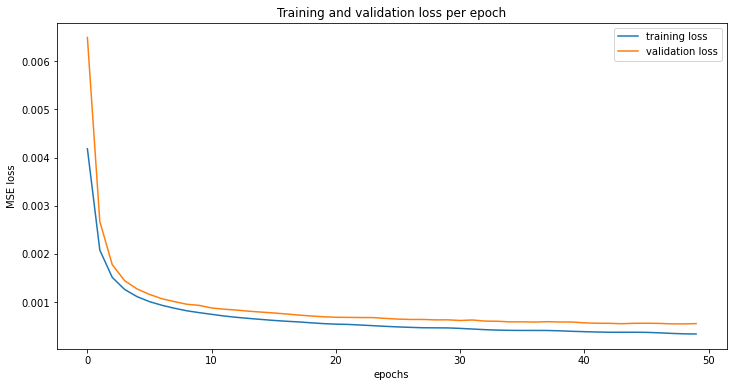

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(range(NUM_EPOCHS), train_losses_epoch, label='training loss')
plt.plot(range(NUM_EPOCHS), val_losses_epoch, label='validation loss')
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.title("Training and validation loss per epoch")
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/train-test-loss_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

# Testing

In [46]:
# get first I/O-sequence of test dataset for visualizing a prediction
for batch in data_module.test_dataloader():
    x_test = batch["input"]
    y_test = batch["output"]
    break

if CUDA:
    x_test = x_test.cuda()
    y_test = y_test.cuda()

print(x_test.shape, y_test.shape)

torch.Size([1, 10, 3, 54, 96]) torch.Size([1, 2, 120])


In [47]:
criterion = nn.MSELoss()

# make one prediction for visualization
with torch.no_grad():
    y_pred = loaded_model(x_test.squeeze(1))
    loss = criterion(y_pred, y_test)

    # clean up tensor and round results to visually compare predicted sequence
    a = y_pred.squeeze(0)[0].tolist()
    a = [round(num, 4) for num in a]

    b = y_test.squeeze(0)[0].tolist()
    b = [round(num, 4) for num in b]

    print(f'predicted pitch: {a}\nreal pitch:\t {b}')
    print("loss:", round(loss.item(), 6))

# squeeze out batch size and convert into cpu format for plotting
x_test.squeeze(0).shape
input_sequence = x_test.squeeze(0).cpu()
output_sequence = y_test.squeeze(0).cpu()
predicted_sequence = y_pred.squeeze(0).cpu()
input_sequence.shape, output_sequence.shape, predicted_sequence.shape

predicted pitch: [0.0049, -0.0053, 0.1289, 0.0958, 0.1289, -0.0148, 0.0976, 0.136, 0.0728, 0.0559, 0.0957, 0.0509, 0.0945, -0.0627, -0.0472, -0.0611, 0.0816, 0.1387, 0.1707, 0.1712, 0.0776, 0.0708, -0.0059, 0.0774, 0.1028, 0.067, 0.0409, 0.0193, 0.1223, 0.0378, -0.0799, 0.0198, 0.051, -0.072, -0.1712, -0.2162, 0.077, 0.2052, 0.176, 0.1634, 0.184, 0.2317, 0.1894, 0.1144, 0.0214, 0.1607, 0.029, 0.0193, 0.0551, 0.0358, -0.0253, -0.0067, -0.0858, 0.0059, 0.0337, 0.0889, 0.1146, 0.0076, -0.0022, -0.0414, -0.0078, -0.1462, -0.0094, 0.0123, -0.0327, -0.0663, -0.1425, -0.1557, 0.0645, 0.0975, 0.0466, 0.0675, 0.0344, -0.0657, -0.1288, -0.128, -0.117, -0.07, 0.0372, 0.0441, 0.025, -0.0907, -0.1201, -0.1434, -0.2093, -0.1151, -0.1584, -0.2118, -0.3302, -0.2645, 0.0021, -0.0048, 0.1073, 0.1203, -0.0612, -0.0125, 0.0491, 0.1494, 0.0376, -0.0558, 0.0462, 0.0489, 0.0681, 0.045, -0.0521, -0.0499, -0.1058, -0.1231, -0.0714, 0.0496, 0.086, 0.0837, 0.0341, -0.071, 0.0463, 0.0612, -0.0058, -0.0334, 0.0803

(torch.Size([10, 3, 54, 96]), torch.Size([2, 120]), torch.Size([2, 120]))

### Prediction vs. real on first test I/O-sequence

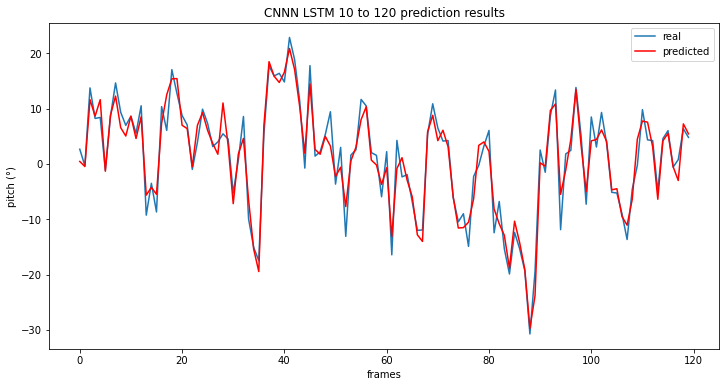

In [48]:
frames = np.arange(0,FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(output_sequence[0].apply_(denorm_pr), label="real")
ax.plot(predicted_sequence[0].apply_(denorm_pr), color="red", label='predicted')
ax.set_xlabel('frames')
ax.set_ylabel('pitch (°)')
ax.set_title(f'CNNN LSTM {FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/1ep_pitch-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

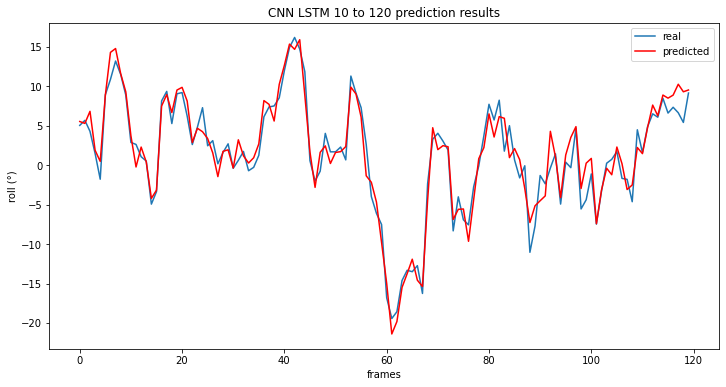

In [49]:
frames = np.arange(0,FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(output_sequence[1].apply_(denorm_pr), label="real")
ax.plot(predicted_sequence[1].apply_(denorm_pr), color="red", label='predicted')
ax.set_xlabel('frames')
ax.set_ylabel('roll (°)')
ax.set_title(f'CNN LSTM {FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/1ep_roll-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

### Full test loop

In [50]:
predictions = []
labels = []

with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader()):
        x_test = batch["input"]
        y_test = batch["output"]

        if CUDA:
            x_test = x_test.cuda()

        output = loaded_model(x_test.squeeze(1))

        # squeeze out batch size which is = 1 for test dataset
        predictions.append(output.cpu().squeeze(0))
        labels.append(y_test.squeeze(0))

  0%|          | 0/29268 [00:00<?, ?it/s]

In [51]:
predictions[0][0]

tensor([ 0.0049, -0.0053,  0.1289,  0.0958,  0.1289, -0.0148,  0.0976,  0.1360,
         0.0728,  0.0559,  0.0957,  0.0509,  0.0945, -0.0627, -0.0472, -0.0611,
         0.0816,  0.1387,  0.1707,  0.1712,  0.0776,  0.0708, -0.0059,  0.0774,
         0.1028,  0.0670,  0.0409,  0.0193,  0.1223,  0.0378, -0.0799,  0.0198,
         0.0510, -0.0720, -0.1712, -0.2162,  0.0770,  0.2052,  0.1760,  0.1634,
         0.1840,  0.2317,  0.1894,  0.1144,  0.0214,  0.1607,  0.0290,  0.0193,
         0.0551,  0.0358, -0.0253, -0.0067, -0.0858,  0.0059,  0.0337,  0.0889,
         0.1146,  0.0076, -0.0022, -0.0414, -0.0078, -0.1462, -0.0094,  0.0123,
        -0.0327, -0.0663, -0.1425, -0.1557,  0.0645,  0.0975,  0.0466,  0.0675,
         0.0344, -0.0657, -0.1288, -0.1280, -0.1170, -0.0700,  0.0372,  0.0441,
         0.0250, -0.0907, -0.1201, -0.1434, -0.2093, -0.1151, -0.1584, -0.2118,
        -0.3302, -0.2645,  0.0021, -0.0048,  0.1073,  0.1203, -0.0612, -0.0125,
         0.0491,  0.1494,  0.0376, -0.05

In [52]:
# Predictions[0] = tensor object
# Predictions[0][0] = pitch value
# Predictions[0][1] = roll value

pitch_predictions = []
roll_predictions = []

pitch_label = []
roll_label = []

for i in range(len(predictions)):
    pitch_predictions.append(predictions[i][0])
    roll_predictions.append(predictions[i][1])
    pitch_label.append(labels[i][0])
    roll_label.append(labels[i][1])

pitch_predictions[0].shape, roll_predictions[0].shape, pitch_label[0].shape, roll_label[0].shape

(torch.Size([120]), torch.Size([120]), torch.Size([120]), torch.Size([120]))

### Average loss-per-frame over all datapoints

In [53]:
# function that returns a list with loss-values per frame
def loss_per_frame(predicted_sequence, real_sequence):
    loss_per_frame = []
    criterion = nn.MSELoss()
    if predicted_sequence.shape != real_sequence.shape:
        return loss_per_frame
    for i in range(len(predicted_sequence)):
        loss = criterion(predicted_sequence[i], real_sequence[i])
        loss_per_frame.append(loss.item())
    return loss_per_frame

In [54]:
# calculate mean loss per frame over all test data
total = len(pitch_predictions)
pitch_total = np.zeros(FRAMES_OUT, dtype=np.float64)
roll_total = np.zeros(FRAMES_OUT, dtype=np.float64)

for i in tqdm(range(len(pitch_predictions))):
    pitch_lpf = loss_per_frame(pitch_predictions[i], pitch_label[i])
    roll_lpf = loss_per_frame(roll_predictions[i], roll_label[i])
    pitch_total += pitch_lpf
    roll_total += roll_lpf

pitch_lpf_mse = pitch_total / total
roll_lpf_mse = roll_total / total

  0%|          | 0/29268 [00:00<?, ?it/s]

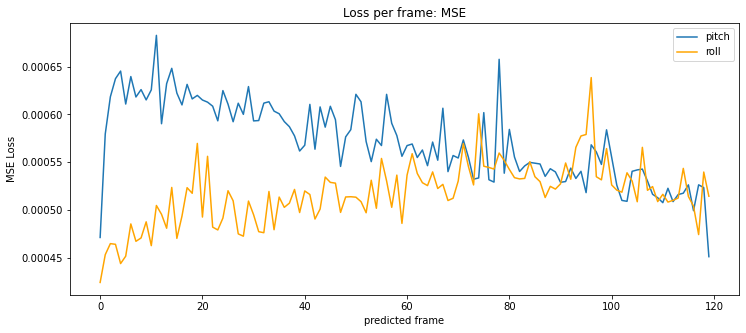

In [55]:
plt.figure(figsize=(12, 5))
plt.plot(pitch_lpf_mse, label='pitch')
plt.plot(roll_lpf_mse, color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('MSE Loss')
plt.title('Loss per frame: MSE')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/LPF-MSE_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

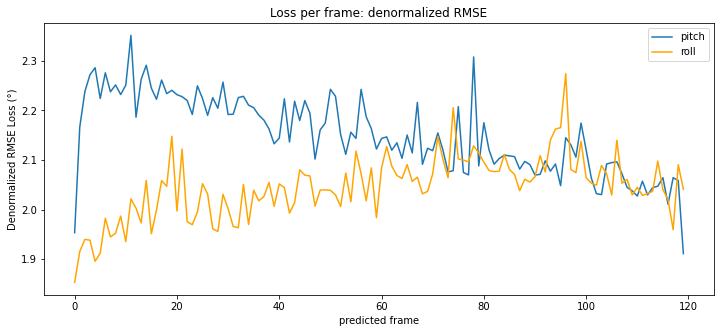

In [56]:
pitch_lpf_rmse = np.sqrt(pitch_lpf_mse)
roll_lpf_rmse = np.sqrt(roll_lpf_mse)
denorm = lambda x: denorm_pr(x)
vfunc = np.vectorize(denorm)
plt.figure(figsize=(12, 5))
plt.plot(vfunc(pitch_lpf_rmse), label='pitch')
plt.plot(vfunc(roll_lpf_rmse), color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('Denormalized RMSE Loss (°)')
plt.title('Loss per frame: denormalized RMSE')
plt.legend()
plt.savefig(f'{RESULT_FOLDER}/LPF-denorm-RMSE_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

### MSE results pitch

In [57]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(pitch_label[i], pitch_predictions[i]).item()
    loss0 += criterion(pitch_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Pitch prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Pitch prediction
   MSE: 0.00057
   RMSE: 0.0239
   RMSE denorm: 2.15°
Zero prediction
   MSE 0: 0.00449
   RMSE 0: 0.067
   RMSE denorm: 6.03°
Improvement on zero prediction:
   MSE delta%: 787.72 %
   RMSE delta%: 280.33 %


### MSE results roll

In [58]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(roll_label[i], roll_predictions[i]).item()
    loss0 += criterion(roll_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Roll prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Roll prediction
   MSE: 0.00052
   RMSE: 0.0227
   RMSE denorm: 2.04°
Zero prediction
   MSE 0: 0.00716
   RMSE 0: 0.0846
   RMSE denorm: 7.61°
Improvement on zero prediction:
   MSE delta%: 1376.92 %
   RMSE delta%: 372.69 %
